In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14,8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
 df = pd.read_csv('creditcard.csv',sep=',')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.isnull().values.any()

False

Text(0, 0.5, 'frequency')

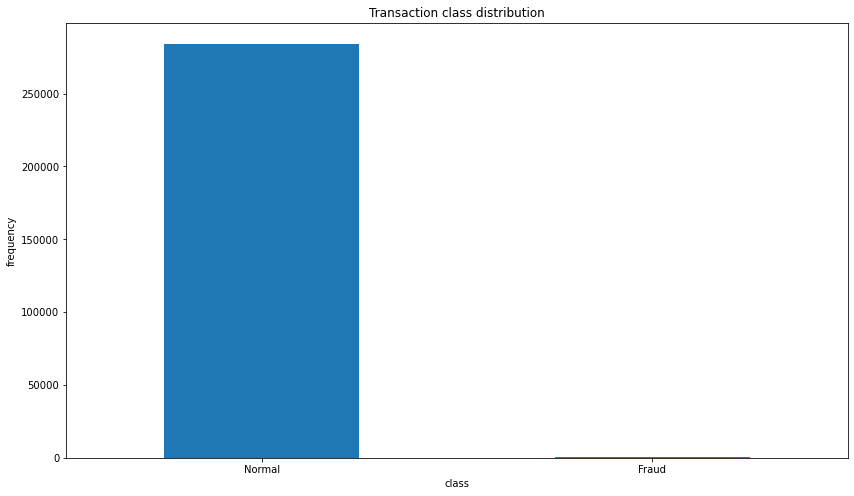

In [5]:
count_class = pd.value_counts(df['Class'], sort=True)
count_class.plot(kind = 'bar' , rot = 0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("class")
plt.ylabel("frequency")

In [6]:
fruad = df[df['Class']==1]
normal = df[df['Class']==0]

In [7]:
print(fruad.shape,normal.shape)

(492, 31) (284315, 31)


In [8]:
fruad.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

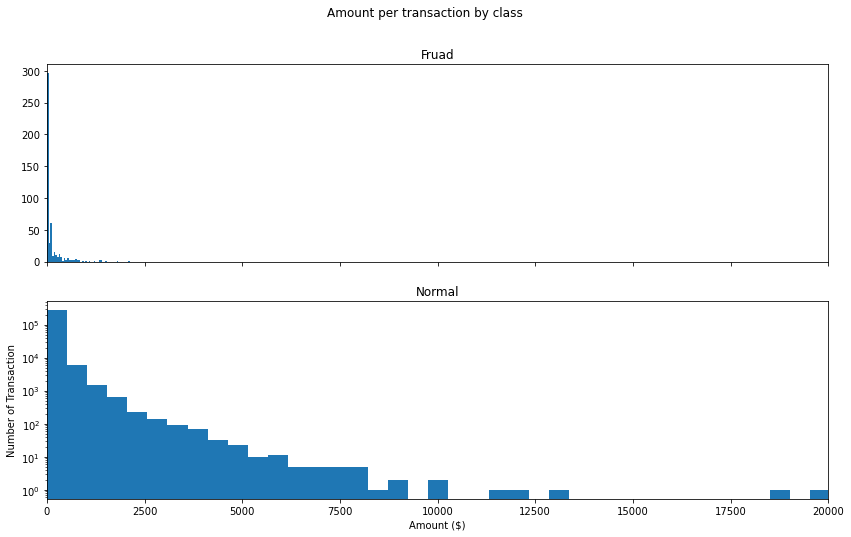

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fruad.Amount, bins = bins)
ax1.set_title("Fruad")
ax2.hist(normal.Amount, bins = bins)
ax2.set_title("Normal")
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transaction')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

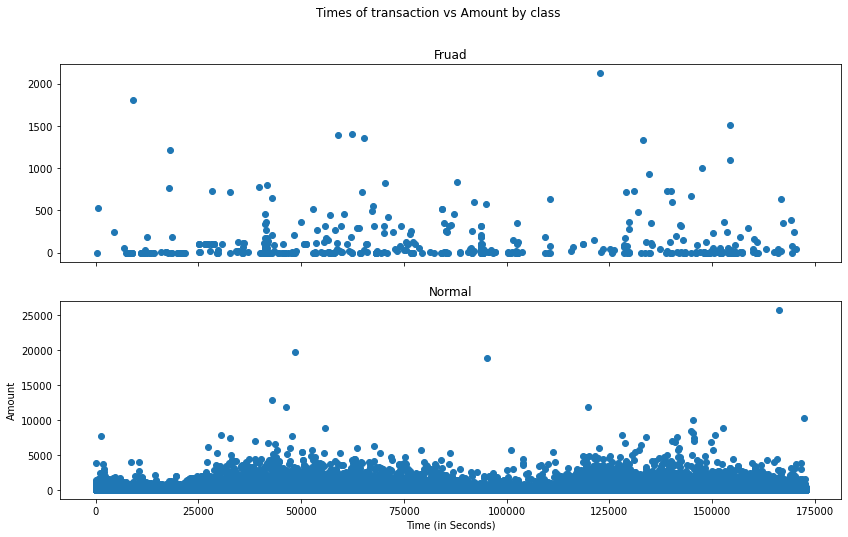

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Times of transaction vs Amount by class')
bins = 50
ax1.scatter(fruad.Time, fruad.Amount)
ax1.set_title('Fruad')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [12]:
data = df.sample(frac= 0.1,random_state= 1)
data.shape

(28481, 31)

In [13]:
Fruad = data[data['Class']==1]
Valid = data[data['Class']==0]
outlier_fraction = len(Fruad)/float(len(Valid))
print(outlier_fraction)

0.0017234102419808666


In [14]:
print(outlier_fraction)
print("fraud Case : {}".format(len(Fruad)))
print("fraud Case : {}".format(len(Valid)))

0.0017234102419808666
fraud Case : 49
fraud Case : 28432


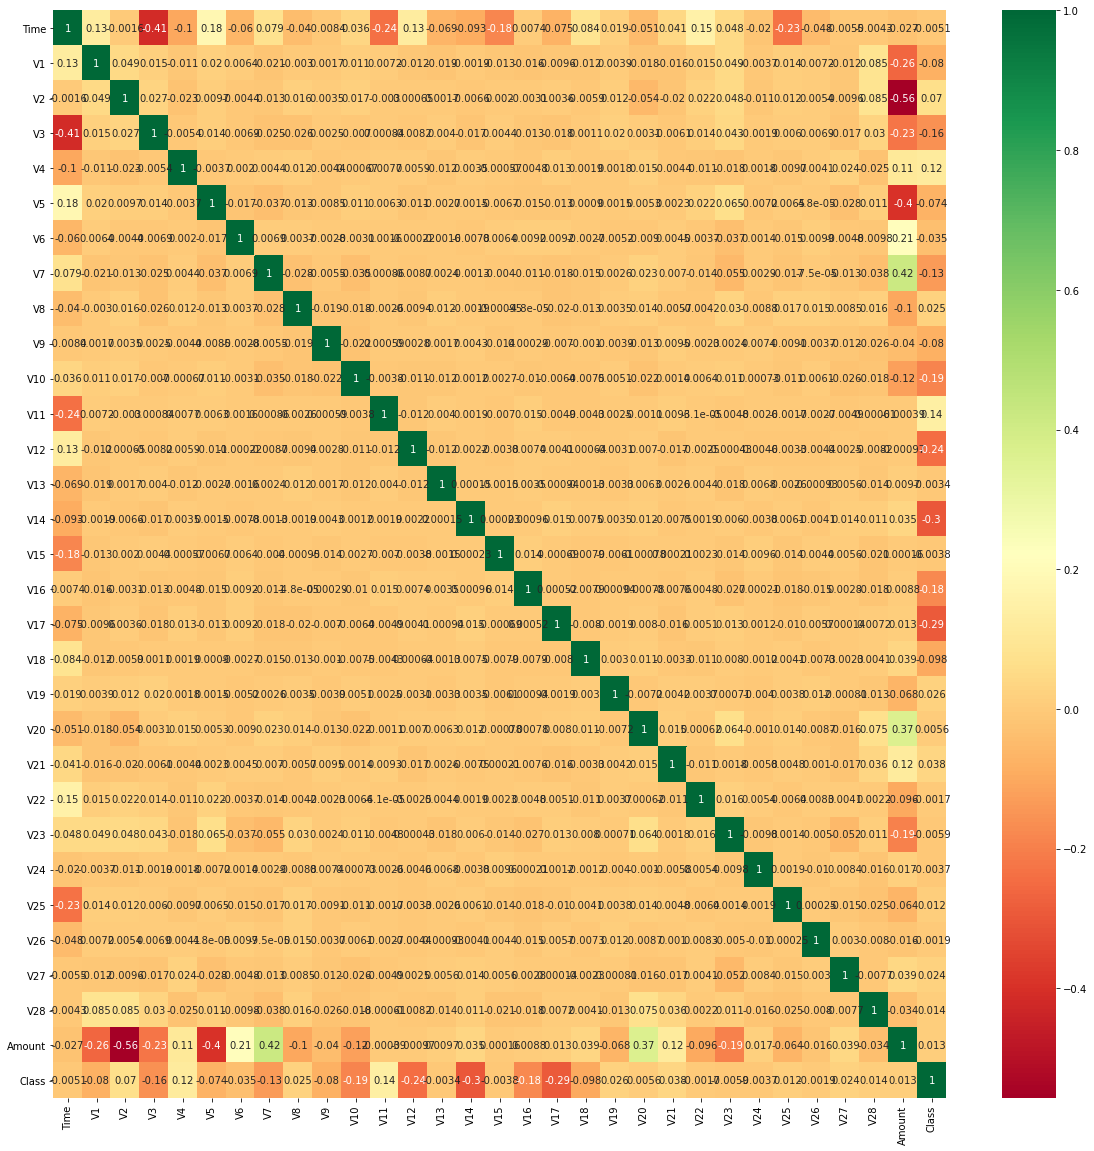

In [15]:
corrmat = data.corr()
top_corr_feature = corrmat.index
plt.figure(figsize=(20, 20))
g = sns.heatmap(data[top_corr_feature].corr(),annot=True,cmap="RdYlGn")

In [16]:
columns = data.columns.to_list()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
x_outliers = state.uniform(low=0, high=0, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [22]:
#define the outlier methods
classifier = {
    "Isolation Forest " : IsolationForest(n_estimators = 100, max_samples = len(X),
                                        contamination = outlier_fraction,random_state=state ,verbose =0),
    "Local Outlier Factor " : LocalOutlierFactor(n_neighbors = 20, algorithm = 'auto',
                                                leaf_size = 30, metric = 'minkowski',novelty=True,
                                                p=2, metric_params=None, contamination= outlier_fraction),
#     "Support Vector Machine " :OneClassSVM(kernel = 'rbf', degree = 3, gamma= 0.1, nu = 0.05,
#                                           max_iter = -1, random_state=state)
}

In [23]:
type(classifier)

dict

In [24]:
n_outliers = len(Fruad)
for i,(clf_name, clf) in enumerate(classifier.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict()
        score_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        score_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    y_pred[y_pred == 1] == 0
    y_pred[y_pred == -1] == 1    
    n_errors = (y_pred != Y).sum()
    print("{}: {}".format(clf_name, n_errors))
    print("Accuracy score: ")
    print(accuracy_score(Y,y_pred))
    print("classidication report: ")
    print(classification_report(Y, y_pred))

Isolation Forest : 28445
Accuracy score: 
0.0012640005617780275
classidication report: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00     28432
           1       0.00      0.73      0.00        49

    accuracy                           0.00     28481
   macro avg       0.00      0.24      0.00     28481
weighted avg       0.00      0.00      0.00     28481



C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Local Outlier Factor : 28433
Accuracy score: 
0.0016853340823707033
classidication report: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00     28432
           1       0.00      0.98      0.00        49

    accuracy                           0.00     28481
   macro avg       0.00      0.33      0.00     28481
weighted avg       0.00      0.00      0.00     28481



C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
